In [157]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
import snips as snp
%matplotlib inline

# Install TensorFlow on Windows and a Virtual Environment

TensorFlow is now supported in Windows, yay! The very simple installation instructions for Windows are [here](https://www.tensorflow.org/install/install_windows). All you need to do to get the non-GPU (normal person with normal laptop) version is create an new virtual environment and install tensorflow:

In [ ]:
conda create --name=tensorflow
conda activate tensorflow 
pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/windows/cpu/tensorflow-1.0.0-cp35-cp35m-win_x86_64.whl

Note that the above `install` command didn't work for me, as documented in this ticket [here](https://github.com/tensorflow/tensorflow/issues/7552) and [here](https://github.com/tensorflow/tensorflow/issues/7859). The solution was to download a nightly build and just directly install the binary wheels file with pip:

In [ ]:
pip install tensorflow-1.0.0-cp35-cp35m-win_amd64.whl

You'll still get warnings, but they are OK. Now, you want to be able to use jupyter notebooks inside your tensorflow environment, so refer to [this great stack overflow explanation](http://stackoverflow.com/questions/30492623/using-both-python-2-x-and-python-3-x-in-ipython-notebook) of how to make Jupyter recognize conda environments as kernels. Essentially you just need your environment to have three packages:

In [ ]:
conda install jupyter
conda install ipykernel
conda install nb_conda_kernels

Then make sure to restart the jupyter server and select kernel > change kernel to change this notebooks environment! Now we are ready to test our tensorflow install! 

In [2]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


<img src="images/post-tensorflow-quickstart/pic1.jpg" width=400></img>

**In the above image squares represent stateful objects whereas circles represent computes.**

# Visualizing Graphs Inline in Jupyter
Thanks to [this stackoverflow answer](http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374) which pointed me to [this awesome notebook](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb) in which some functions are defined for inline visualization (relying on the built-in TensorBoard visualization capabilities). Copy/pasting from there (but commenting out so that my "notebook to HTML plugin" for generating articles doesn't act funny):

In [30]:
# from IPython.display import clear_output, Image, display, HTML

# # Helper functions for TF Graph visualization
# def strip_consts(graph_def, max_const_size=32):
#     """Strip large constant values from graph_def."""
#     strip_def = tf.GraphDef()
#     for n0 in graph_def.node:
#         n = strip_def.node.add() 
#         n.MergeFrom(n0)
#         if n.op == 'Const':
#             tensor = n.attr['value'].tensor
#             size = len(tensor.tensor_content)
#             if size > max_const_size:
#                 tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
#     return strip_def
  
# def rename_nodes(graph_def, rename_func):
#     res_def = tf.GraphDef()
#     for n0 in graph_def.node:
#         n = res_def.node.add() 
#         n.MergeFrom(n0)
#         n.name = rename_func(n.name)
#         for i, s in enumerate(n.input):
#             n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
#     return res_def
  
# def show_graph(graph_def=None, max_const_size=32):
#     """Visualize TensorFlow graph."""
    
#     # If no input graph is given, get the default graph
#     if graph_def is None:
#         graph_def = tf.get_default_graph().as_graph_def()
        
#     if hasattr(graph_def, 'as_graph_def'):
#         graph_def = graph_def.as_graph_def()
#     strip_def = strip_consts(graph_def, max_const_size=max_const_size)
#     code = """
#         <script>
#           function load() {{
#             document.getElementById("{id}").pbtxt = {data};
#           }}
#         </script>
#         <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
#         <div style="height:600px">
#           <tf-graph-basic id="{id}"></tf-graph-basic>
#         </div>
#     """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
#     iframe = """
#         <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
#     """.format(code.replace('"', '&quot;'))
#     display(HTML(iframe))

Also check out this good article on how to use `name`s and namespaces in your graph to get [sensible and legible visualizations](https://medium.com/intuitionmachine/teasing-out-tensorflow-graph-mess-64cf5ece4b00#.66qfwd6sc) from TensorBoard. It follows the [official docs](https://www.tensorflow.org/versions/master/how_tos/graph_viz/) on the same topic.

Finally, another helpful thing to know before starting is the function to clear the default graph of all its nodes so you can start fresh:

In [28]:
tf.reset_default_graph()  # To clear the default graph 

# Computational Graphs 
The key to not being intimidated by tensor flow is having a basic grasp of what computational graphs are *before* you jump in. There are only two resources you need here, and I recommend you avail yourself of both:

- [Christopher Olah's excellent and short blog post](http://colah.github.io/posts/2015-08-Backprop/) on computational graphs and backprop.
- [Andrej Karpathy's excellent video lecture](https://www.youtube.com/watch?v=GZTvxoSHZIo&list=PLlJy-eBtNFt6EuMxFYRiNRS07MCWN5UIA&index=4) introducing computational graphs. You only need to watch the first 50 minutes.


# Walkthrough of TensorFlow Official "Get Started" Guide
This is a walk-through of the official "Get Started" tutorial under the "Develop" tab at tensorflow.org [here.](https://www.tensorflow.org/get_started/get_started) In my walkthrough I will show the evolution of the computational graph in a lot more detail and I try to explain the steps in terms of editing the graph.

### Overview
TensorFlow exposes various levels of API, the high-level one is `tf.contrib.learn`, but many people instead use the external python library `keras` to provide a simpler high-level syntax for working with TF. The lowest level API is called `TensorFlow Core` (TFC) and provides the maxmium amount of flexibility. TFC scripts consist of building a computational graph and then running that graph. According to the documentation:
> A computational graph is a series of TensorFlow operations arranged into a graph of nodes... Each node takes zero or more tensors as inputs and produces a tensor as an output.

This is the source of the name "TensorFlow" - the basic function of this tool is to flow tensors around in a graph! Remember, tensors can be scalar constants, vectors, matrices and higher-dimensional arrays. 

### Constants 
One type of node is `tf.constant` which takes zero inputs and outputs a stored 0D tensor. The *value* of a constant node is *not* it's stored value, instead when that node is evaluted during the running a graph it outputs its stored value. A graph can also include **operation nodes** like `tf.add`.

You use your python or C++ front-end (THIS) to build your graph, but then the graph is sent to your runtime for actual computation. You talk to the run-time via a `Session`, which is the object responsible for controlling and holding state for the TF runtime. 

We can build a simple graph with a few constants and a few operations and then run it to force those nodes to be evaluated. Notice we can give names to our nodes and make the graph easier to understand:

In [316]:
tf.reset_default_graph()  # To clear the default graph 

node1 = tf.constant(3.0, name="firstconst")
node2 = tf.constant(4.0, name="secondconst")
node3 = tf.add(node1, node2, name="sum")
node4 = tf.divide(node3, node1, name="sumdiv")

sess = tf.Session()
sess.run([node1, node2, node3, node4])

[3.0, 4.0, 7.0, 2.3333333]

When we visualize this graph we see circles represent constant nodes and ovals represent operation nodes! Also notice that little arrows with flat heads are indicating the flow of constants into nodes, while large arrows with curved heads are indicating the flow of data from one node to another.

In [314]:
show_graph()

Visualizing the graph very helpful, but you can also see a full specification of the graph in a JSON-like syntax by using:

In [315]:
graphdef = tf.get_default_graph().as_graph_def()
nodes = iter(graphdef.node)
print(next(nodes))

name: "firstconst"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_FLOAT
      tensor_shape {
      }
      float_val: 3.0
    }
  }
}



### Placeholders
What if we don't want to hardcode the values for `node1` and `node2` but instead provide them at runtime? A **placeholder node is a stand in for a constant value that will be provided later.** You pass a dictionary of values or sets of values to the session at runtime and those values stay fixed during the running of the graph.

In [105]:
tf.reset_default_graph()  # To clear the default graph 

a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b  # + provides a shortcut for tf.add(a, b)

show_graph()

In this case we can see that the placeholder is actually an operation, not a constant, and it flows data to the sum operation node. Also notice the naming convention that TF is substituting since we didn't pass our own values of the `name` kwarg.

In [106]:
sess = tf.Session()
print(sess.run(adder_node, {a: [1,3], b: [2, 4]}))

[ 3.  7.]


### Variables 

In contrast to a constant with a fixed value at definition or a placeholder with fixed value that is passed at runtime, a **variable node is a trainable parameter of your graph in that it's value can change during running.**

In [122]:
tf.reset_default_graph()  # To clear the default graph 

W = tf.Variable([.3], tf.float32, name="W")
b = tf.Variable([-.3], tf.float32, name="b")
x = tf.placeholder(tf.float32, name="x")

show_graph()

Now `W`, `b` and `x` are node TF objects, but we can use standard python math to create new operations and flow edges from them. In this case, the handle `linear_model` is pointing at the sub-graph (subset of nodes and edges) that encompass the calculation:

In [123]:
linear_model = W * x + b
show_graph()

Here a multiply operation receives data flowed from the placeholder `x` and variable `W` and the ouput is flowed into an add operation node together with data from variable `b`. You must provide an initialization value to `tf.Variable` during declaration, but the initialization won't actually be executed until create initialization nodes and then run the graph asking it to evaluate those nodes. The convenience function `tf.global_variables_initializer()` creates the appropriate nodes and returns a handle to them that you can pass to `run`.

In [125]:
# Initialize all the variables
init = tf.global_variables_initializer() # Create nodes necessary for initialization, return handle to subgraph
print(init)
show_graph()

name: "init"
op: "NoOp"
input: "^W/Assign"
input: "^b/Assign"



Notice that a new "auxiliary" graph appears with the `init` node ("auxilliary" is just a visualization scheme, it doesn't actually mean anything in terms of the computational structure of the graph). By asking the runtime to evaluate the `init` node, we execute computations that set the values of `W` and `b` with their initialization values. Since the graph holds state, those are now the starting values for our variables. Note that we can NOT just ask the runtime to evaluate other nodes in the graph and expect it to do the initialization first. 

In [127]:
# Run the graph with initialization computations in the graph
sess = tf.Session()
sess.run(init)

After initialization we can ask the session to run the graph to evaluate the output of the `linear_model` node given a bunch of values to the placeholder `x`. 

In [129]:
# Run the graph to evaluate the node linear_model for different placeholder values
sess.run(linear_model, {x:[1,2,3,4]})

array([ 0.        ,  0.30000001,  0.60000002,  0.90000004], dtype=float32)

### Losses
So we built a model that can take in a vector of different values of $x$ and produce an output vector $y$ which is a linear function of $x$ depending on the value of the variable nodes. To evaluate how well this output $y$ of our model compares with some real values of $y$ that we have, we need to define a loss function. A common loss is the squared difference between the ouput and the ground truth (observed) $y$ - this is already implemented in TF:

In [131]:
# Add nodes into our pre-existing graph
y = tf.placeholder(tf.float32, name="y")  # The ground truth passed at runtime
squared_deltas = tf.square(linear_model - y, name="sq_err")  # Subgraph to get a vector of sq. errs.
loss = tf.reduce_sum(squared_deltas, name="sq_err_sum")  # Subgraph that sums across the vector ("reduces")

show_graph()

The call to `tf.square(linear_model - y)` created two nodes, one for the subtraction operation and one for the square, whereas the call to `tf.reduce_sum` has created a whole set of new nodes that will help compute the single number that is sum of squared errors given input vectors $\vec{x}$ and $\vec{y}$. We can imagine that `Rank` takes in the tensor output of `err` and outputs the dimensions of that `tensor` - this is then fed into `range` which creates a set of indices for which elements will be involved in the final sum (all of them in this case). This range tensor and the tensor holding the actual errors, `err` then get fed into a `sum` operation node. 

In [132]:
# Evaluate the loss subgraph with a set of inputs x and y
sess.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]})  # Run graph to compute the output of the loss node

23.66

### Optimizers (Training)
Obviously we don't want to manually change the values of `W` and `b` based on guesswork. Instead we want to algorithmically change their values to minimize the tensor output of `loss` i.e. we want to train our model and learn good values for these parameters. The machines to do this are "optimizer" classes. **The optimizer is not a node or subgraph, but it it has methods that build the subgraphs necessary for optimization.** For intance, to build a subgraph that minimizes the output of our `loss` subgraph we can do:

In [148]:
optimizer = tf.train.GradientDescentOptimizer(0.0002)
train_step = optimizer.minimize(loss)
show_graph()

This is looking a little messier now but still interpretable. The nodes in our original graph now also output tensors to a new node `gradients`. The output tensor of `gradients` is fed into a second new node `GradientDescent` which also takes tensor input from `W` and `b`. 

Instead of using the convenience `minimize` method, we could actually have created these two pieces independently with the code:

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
grads_and_vars = optimizer.compute_gradients(loss)  # Subgraph to compute gradients of loss w.r.t. all Variable nodes (default)
updates = optimizer.apply_gradients(grads)  # Subgraph to update the Variable nodes using the computed gradients

### Operations Details of Graph
Visualizing operations as nodes hides a lot of what happens when we run this graph - each node can entail a large block of functional code. We can see more details of what happens in each node with the `get_operations()` method of our graph:

In [150]:
for op in tf.get_default_graph().get_operations(): print(op.name)

W/initial_value
W
W/Assign
W/read
b/initial_value
b
b/Assign
b/read
x
mul
add
init
y
sub
sq_err
Rank
range/start
range/delta
range
sq_err_sum
gradients/Shape
gradients/Const
gradients/Fill
gradients/sq_err_sum_grad/Shape
gradients/sq_err_sum_grad/Size
gradients/sq_err_sum_grad/add
gradients/sq_err_sum_grad/mod
gradients/sq_err_sum_grad/Shape_1
gradients/sq_err_sum_grad/range/start
gradients/sq_err_sum_grad/range/delta
gradients/sq_err_sum_grad/range
gradients/sq_err_sum_grad/Fill/value
gradients/sq_err_sum_grad/Fill
gradients/sq_err_sum_grad/DynamicStitch
gradients/sq_err_sum_grad/Maximum/y
gradients/sq_err_sum_grad/Maximum
gradients/sq_err_sum_grad/floordiv
gradients/sq_err_sum_grad/Reshape
gradients/sq_err_sum_grad/Tile
gradients/sq_err_grad/mul/x
gradients/sq_err_grad/mul
gradients/sq_err_grad/mul_1
gradients/sub_grad/Shape
gradients/sub_grad/Shape_1
gradients/sub_grad/BroadcastGradientArgs
gradients/sub_grad/Sum
gradients/sub_grad/Reshape
gradients/sub_grad/Sum_1
gradients/sub_grad

Now we can see that the `gradients` node is computing gradients, while the `GradientDescent` node is "updating" or modifying the values of `W` and `b`. 

### Training the Model
To actually "train" this model is as simple as running the graph by feeding in a set of sample points via our placeholders `x` and `y`. For each pair of values the `GradientDescent` node will update the value of `W` and `b`, and if we want to do multiple passes through our sample data (epochs) the graph will hold state in between them. First let's make some data which corresponds to a real-world noisy relationship $y(x)$:

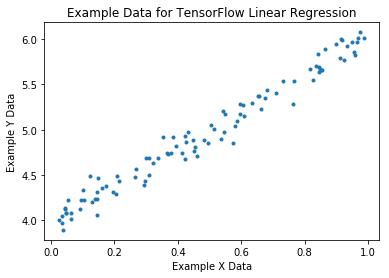

In [271]:
# Make date for the model y = 2x + 4 + random noise and plot it
x_train = np.random.rand(100).astype(np.float32)
noise = np.random.normal(scale=0.1, size=len(x_data))
y_train = 2*x_train + 4 + noise

pylab.plot(x_train, y_train, '.')
snp.labs("Example X Data", "Example Y Data", "Example Data for TensorFlow Linear Regression")

Here we reproduce just the code for building the linear model:

In [286]:
tf.reset_default_graph()

# Model parameters
W = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)

# Model input and output
x = tf.placeholder(tf.float32)
linear_model = W * x + b
y = tf.placeholder(tf.float32, name="y")  # The ground truth passed at runtime

# Loss
squared_deltas = tf.square(linear_model - y, name="sq_err")  # Subgraph to get a vector of sq. errs.
loss = tf.reduce_sum(squared_deltas, name="sq_err_sum")  # Subgraph that sums across the vector ("reduces")

# Optimization Algorithm
optimizer = tf.train.GradientDescentOptimizer(0.001)
train_step = optimizer.minimize(loss)

Here is what's needed for training and evaluation the model:

In [293]:
# Training the Model
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) 
ws, bs, ls = [], [], []
for i in range(200):
    ww, bb, los, trash = sess.run([W, b, loss, train_step], {x:x_train, y:y_train})
    ws.append(ww)
    bs.append(bb)
    ls.append(los)

# Evaluate performance
fitted_W, fitted_b, optimized_loss  = sess.run([W, b, loss], {x:x_train, y:y_train})
print("W = %s \nb = %s \nloss= %s" % (fitted_W, fitted_b, optimized_loss))

W = [ 2.06066775] 
b = [ 3.96328449] 
loss= 1.05975


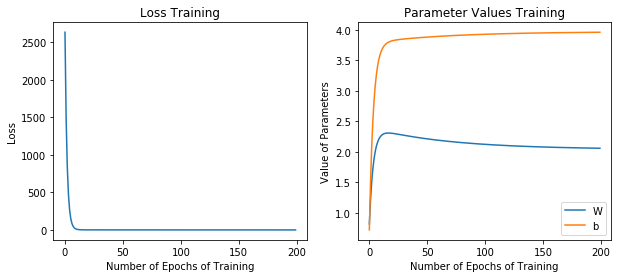

In [294]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
snp.labs("Number of Epochs of Training", "Loss", "Loss Training", axs[0])
axs[0].plot(ls)
snp.labs("Number of Epochs of Training", "Value of Parameters", "Parameter Values Training", axs[1])
axs[1].plot(ws, label="W")
axs[1].plot(bs, label="b")
axs[1].legend(loc="best")

After 200 passes through the data we've converged pretty closely to the true generating function for this data, $y=2x+4$!

### Resources
- A very [clear introduction](https://www.oreilly.com/learning/hello-tensorflow) to the basics of tensorflow archiecture and how it actually executes. Gets into the nuts and bolts a bit.
- [Tutorials and How-Tos](https://www.tensorflow.org/versions/master/tutorials/) on the master branch of tensorflow
- [Official intro to visualizing the graph with TensorBoard](https://www.tensorflow.org/versions/master/how_tos/graph_viz/)